# Notebook's reference
- Pythonのstatsmodelsで時系列分析をする  
https://qiita.com/hcpmiyuki/items/b1783956dee20c6d4700
- 時系列解析に出てくるARIMAモデルとSARIMAモデルを徹底解説  
https://bigdata-tools.com/arima-sarima-model/

In [1]:
import itertools
import tqdm
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


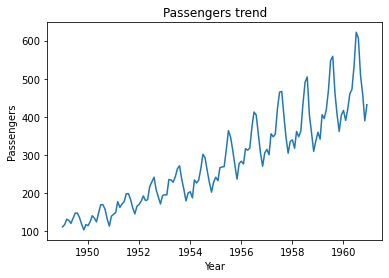

In [2]:
data = pd.read_csv("AirPassengers.csv", 
                   index_col="Month", 
                   parse_dates=True, 
                   )

fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(data["#Passengers"])

ax1.set_title("Passengers trend")
ax1.set_xlabel("Year")
ax1.set_ylabel("Passengers")

plt.show()

In [3]:
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


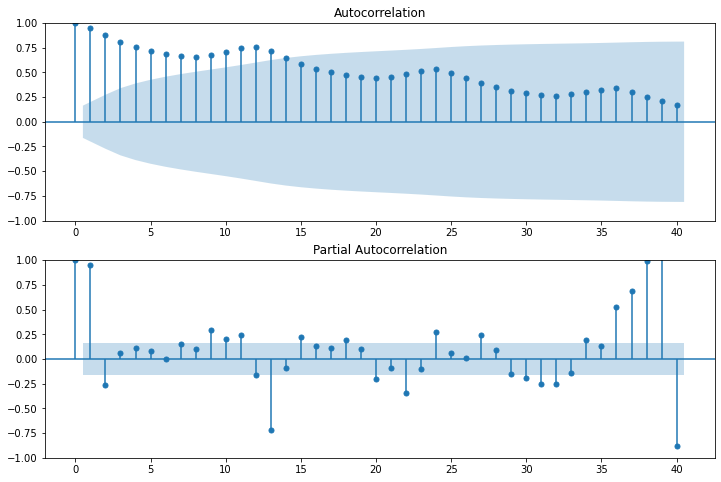

In [4]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data, lags=40, ax=ax2)

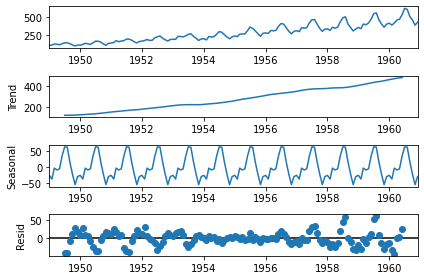

In [5]:
seasonal_decompose_res = sm.tsa.seasonal_decompose(data)
_ = seasonal_decompose_res.plot()

In [6]:
p = q = range(0,3)
d = range(0,2)
s_p = s_d = s_q = range(0, 2)
pdq = list(itertools.product(p, d, q))
pdq_season = [(x[0], x[1], x[2], 12) 
              for x in list(itertools.product(s_p, s_d, s_q))]

In [7]:
train = data[:"1957-12-31"].copy()
train.index = pd.DatetimeIndex(train.index).to_period('M')

In [8]:
warnings.filterwarnings("ignore") 

In [9]:
n_est = len(pdq)*len(pdq_season)
model_select = pd.DataFrame(index=range(n_est), 
                            columns=["order","seasonal_order","aic"])

num = 0
for param in tqdm.tqdm(pdq):
    for param_season in pdq_season:
        model_sarimax = sm.tsa.SARIMAX(
            train,
            order=param,
            seasonal_order=param_season,
        )
        res = model_sarimax.fit(disp=False)
        model_select.loc[num] = [param, param_season, res.aic]
        num += 1

100%|██████████| 18/18 [00:43<00:00,  2.40s/it]


In [10]:
warnings.resetwarnings()

In [11]:
model_select = model_select.sort_values(by="aic")
model_select

,order,seasonal_order,aic
74,"(1, 1, 0)","(0, 1, 0, 12)",704.001168
78,"(1, 1, 0)","(1, 1, 0, 12)",704.185643
138,"(2, 1, 2)","(0, 1, 0, 12)",704.293725
34,"(0, 1, 1)","(0, 1, 0, 12)",704.375863
75,"(1, 1, 0)","(0, 1, 1, 12)",704.471858
...,...,...,...
9,"(0, 0, 1)","(0, 0, 1, 12)",1255.765328
16,"(0, 0, 2)","(0, 0, 0, 12)",1301.741646
8,"(0, 0, 1)","(0, 0, 0, 12)",1357.717783
1,"(0, 0, 0)","(0, 0, 1, 12)",1395.203115


In [12]:
min_model = model_select.iloc[0]
model_final = sm.tsa.SARIMAX(
    train,
    order = min_model.order,
    seasonal_order=min_model.seasonal_order
)
results = model_final.fit(disp=False)
 
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        #Passengers   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -350.001
Date:                            Sun, 10 Jul 2022   AIC                            704.001
Time:                                    07:36:47   BIC                            709.109
Sample:                                01-31-1949   HQIC                           706.065
                                     - 12-31-1957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2411      0.091     -2.648      0.008      -0.420      -0.063
sigma2        92.7499     13.439   

In [13]:
ljungbox_result = sm.stats.diagnostic.acorr_ljungbox(results.resid, lags=10)
ljungbox_result

,lb_stat,lb_pvalue
1,0.000442,0.983222
2,0.648912,0.722920
3,1.068286,0.784735
4,1.223401,0.874231
5,1.600094,0.901238
6,1.629495,0.950434
7,2.276022,0.942999
8,2.769936,0.947955
9,2.955801,0.966022
10,4.450808,0.924728


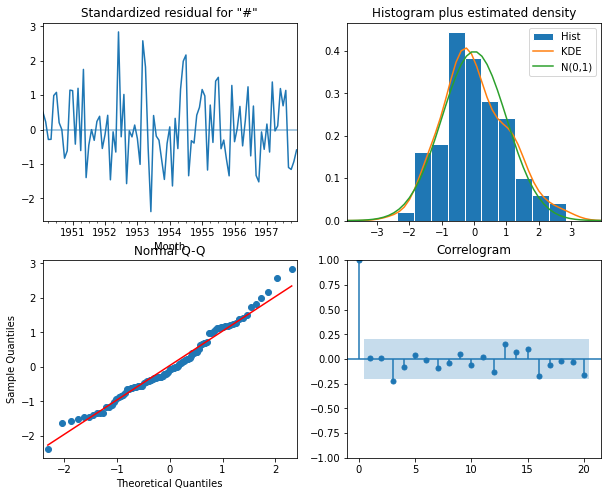

In [14]:
_ = results.plot_diagnostics(figsize=(10,8), lags=20)

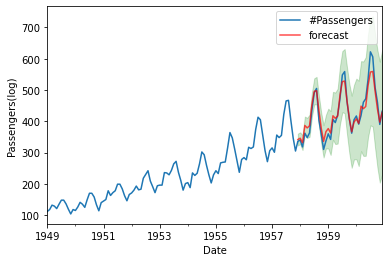

In [15]:
pred = results.get_prediction(start=pd.to_datetime("1957-12-01"),
                              end = pd.to_datetime("1960-12-01"),
                              dynamic=False)

# 期待値と信頼区間を取り出す
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha = .05)

# グラフの描画
data["1949-01-01":].plot(label="observed")
pred_mean.plot(label="forecast", alpha=.7, color = "r")
 
# 信頼区間の描画
plt.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='g', alpha=.2)
 
plt.xlabel("Date")
plt.ylabel("Passengers(log)")
plt.legend()